# 2D Grid World - Loop Walker with Monte Carlo Tree Search (MCTS)

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../packages")
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
import collections
import random

import floorplan
from learners.q_learning import QLearningLearner
from floorplan.envs.loopwalkergridworld import LoopWalkerGridWorldV2,LoopWalkerGridWorldV3, GymEnvMCTSWrapper
from learners.on_policiy_firstvisit_mc import OnPolicyFirstVisitMCCLearner
from floorplan.mcts import mcts


# MCTS Wrapper

The mcts (https://github.com/pbsinclair42/MCTS) package requires to provide an environment which implements the following interface (from official doc):

- __getPossibleActions()__: Returns an iterable of all actions which can be taken from this state
- __takeAction(action)__: Returns the state which results from taking action action
- __isTerminal()__: Returns whether this state is a terminal state
- __getReward()__: Returns the reward for this state. Only needed for terminal states.

Therefore we created a wrapper for our LoopWalker Gym environment:

In [3]:
# dummy only! -> see loopwalkergridworld.py for implementation
class _GymEnvMCTSWrapper():
    
    def __init__(self, env):
        self.env = env
        self.env.reset()
        
        # setup iterable of available actions as integers
        assert isinstance(self.env.action_space, (spaces.Discrete)), "Only 1-dimensional discrete action_space implemented so far"
        self.actions = tuple([a for a in range(self.env.action_space.n)])
        

    def getPossibleActions(self):
        return self.actions

    def takeAction(self, action):
        self.state, self.reward, self.done, _ = self.env.step(action)
        return self

    def isTerminal(self):
        if self.done:
            self._reset()
            return True
        return False

    def getReward(self):
         return self.env.evaluateState()
        
    def _reset(self):
        self.done = False
        self.env.reset()

## Reset environment to specific state

As MCTS as a decision time planning tool (in this case a rollout-algorithm) needs to be able to simulate multiple paths __from any given state__, we also needed an ability to initilize our environment to a particualr state (rather than just the static start-state initialized by the env.reset()).

We implemented a snapshot and restoreFromSnapshot method which creates a deep-copy of all the relevant internal state-variables and restores them if needed. This looked like a good compromise between ease of implementation and runtime-performance.

## MCTS enhanced Q-Learning

The last step is to incorporate the mcts into the classical reinforcement learning algorithm. We use our Q-Learning agent in this case. The _getAction_ method is the ideal place to overwrite the e-greedy action selection with our better informed mcts estimation. We still leave the e-greedy scheme in place and in the epsilon-case we return our best estimated action from mcts instead of a random guess.

In [7]:
class QLearningMCTSLearner(QLearningLearner):

    def __init__(self, env, timeLimit=None, iterationLimit=None,explorationConstant=None):
        super().__init__(env)
        self.mctsEnv = GymEnvMCTSWrapper(env)
        self.mcts = mcts(timeLimit=timeLimit, iterationLimit=iterationLimit, explorationConstant=explorationConstant)
        
    def getAction(self, s, epsilon):
        if np.random.uniform() < epsilon:
            # best action according to time-bounded mcts estimation
            self.env.takeSnapshot()
            ai = self.mcts.search(initialState=self.mctsEnv)
            self.env.restoreLastSnapshot()
            
        else:
            return super().getAction(s,epsilon)
        return ai

In [8]:
# augmented only with debugging-information
def randomRolloutPolicy(state):
    global global_i
    while not state.isTerminal():
        try:
            action = random.choice(state.getPossibleActions())
        except IndexError:
            raise Exception("Non-terminal state has no possible actions: " + str(state))
        state = state.takeAction(action)
    
    # rollout finished -> display results for debugging
    global_ax[global_i%10].imshow(state.env.render())
    r = state.getReward()
    global_ax[global_i%10].set_title(r)
    global_i += 1
    return r

## Baseline

Use our vanilla Q-Learning agent as a baseline with 400 training episodes

trained for 400 episodes each, linearly decr. epsiolon every 40 episodes, 100 mcts-samples per step
Wall time: 4.85 s


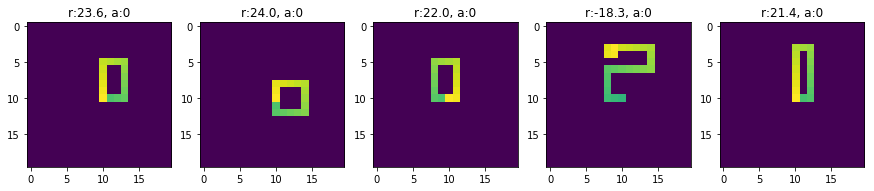

In [142]:
%%time
gridSize=20
targetArea=[16]
alpha = 0.9
gamma = 1
nExperiments = 5
decEpsilonBy = 0.1
decEpsilonEvery = 40
mctsSamplesPerStep = 100
wallCost = 0.1
cornerCost = 0.4 * 4 ############ NEW
failCost = 3
run = None #'_exp_test_27'
np.random.seed(23)
############################
print('trained for %i episodes each, linearly decr. epsiolon every %i episodes, %i mcts-samples per step' % (decEpsilonEvery/decEpsilonBy, decEpsilonEvery, mctsSamplesPerStep))
fig, ax = plt.subplots(1,max([2,nExperiments]), figsize=(15,5))
for _ in range(nExperiments):
    env = LoopWalkerGridWorldV2()
    env.setup(h=gridSize,w=gridSize,a=targetArea,wallCost=wallCost, cornerCost=cornerCost, failCost=failCost)
    learner = QLearningLearner(env)
    _run = run + '_' + str(_) if not run is None else None
    learner.train(epsilon=1000, alpha=1000, gamma=1000, nEpisodes=0, reset=True, run=_run)
    epsilon = 1
    while epsilon > 0:
        epsilon -= decEpsilonBy
        learner.train(epsilon=epsilon, alpha=alpha, gamma=gamma, nEpisodes=decEpsilonEvery, abortIf=-30, reset=False, run=_run)
    greedyReward = learner.runEpisode(0.0, abortIf=-30)
    ax[_].imshow(learner.env.render())
    ax[_].set_title('r:%.1f, a:%d' % (greedyReward, learner.env._polyArea()))
    sys.stdout.write('\rProgress: %i' % (_))
sys.stdout.write("\r\033[K")

With just 400 training episodes the agent converges to a valid policy in 4 out of 5 cases

## Use MCTS for exploration



trained for 400 episodes each, linearly decr. epsiolon every 40 episodes, 100 mcts-samples per step
Wall time: 9min 20s


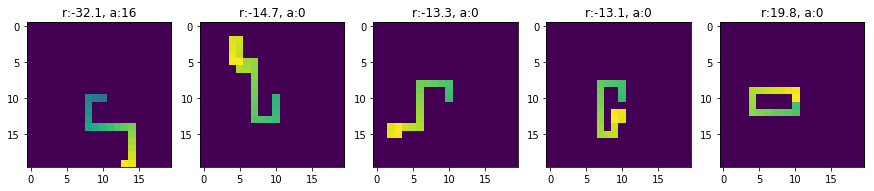

In [141]:
%%time
gridSize=20
targetArea=[16]
alpha = 0.9
gamma = 1
nExperiments = 5
decEpsilonBy = 0.1
decEpsilonEvery = 40
mctsSamplesPerStep = 100
wallCost = 0.1
cornerCost = 0.4 * 4 ############ NEW
failCost = 3
run = None #'_exp_test_27'
np.random.seed(23)
############################
print('trained for %i episodes each, linearly decr. epsiolon every %i episodes, %i mcts-samples per step' % (decEpsilonEvery/decEpsilonBy, decEpsilonEvery, mctsSamplesPerStep))
fig, ax = plt.subplots(1,max([2,nExperiments]), figsize=(15,5))
for _ in range(nExperiments):
    env = LoopWalkerGridWorldV2()
    env.setup(h=gridSize,w=gridSize,a=targetArea,wallCost=wallCost, cornerCost=cornerCost, failCost=failCost)
    #learner = QLearningLearner(env)
    learner = QLearningMCTSLearner(env,iterationLimit=mctsSamplesPerStep,explorationConstant=30)
    _run = run + '_' + str(_) if not run is None else None
    learner.train(epsilon=1000, alpha=1000, gamma=1000, nEpisodes=0, reset=True, run=_run)
    epsilon = 1
    while epsilon > 0:
        epsilon -= decEpsilonBy
        learner.train(epsilon=epsilon, alpha=alpha, gamma=gamma, nEpisodes=decEpsilonEvery, abortIf=-30, reset=False, run=_run)
    greedyReward = learner.runEpisode(0.0, abortIf=-30)
    ax[_].imshow(learner.env.render())
    ax[_].set_title('r:%.1f, a:%d' % (greedyReward, learner.env._polyArea()))
    sys.stdout.write('\rProgress: %i' % (_))
sys.stdout.write("\r\033[K")

That does not seem to work... Even for 100 MCTS rollouts per step the estimation does not seem to be accurate and the guess of mcts in the epsilon case often results in the poor "fail-fast" action. The result seems typical for this sort of environment (episodic) and reward function. Every step decreases the final reward (building cost). Beside that its unlikely to constuct a near optimal floorplan with the expected area while minimizing walls and corners just by random sampling. So on average, sampling an episode by chance will have higher costs (less reward) than just doing a move which leads to termination.

Increasing the penalty for invalid moves does not help here as well because even the best next step very often results in an invalid move later, terminating the episode with this penalty. Therefore the penalty acts more or less as a constant in this opitmiziation problem.

With this in mind, its clear that using the epsilon greedy scheme from above (which works by its own using the partial rewards as shown in the baseline) in combination with the MCTS planning in the epsilon case does not work. In the exploration phase mcts suggests the same non-optimal action very frequently (see below) and prevents q-learning from even getting experinece on the other actions. 

## Variance of Monte Carlo estimates

To investigate the variance of the mcts estimates we execute 100 mcts rollouts from a given starting state. The number, max, average and standard deviation of the experienced results grouped by the first action choice was monitored.

The optimal action would be 2 i.e. _down_. However executing the script below will output 3 i.e. _right_ in most of all cases. Even tought action 2 often has the heightest maximum value action 3's averge is often higher and has much less variance (due to early fail and termination).

3
first action distr:  [18, 8, 13, 61]
max:  [-5.7, -11.2, 2.3, -1.9]
mean:  [-20.2, -29.5, -22.3, -6.8]
std :  [19.6, 13.8, 16.4, 6.6]


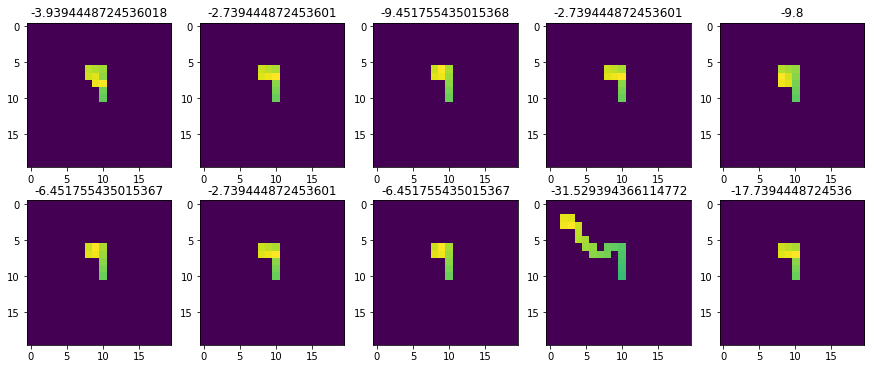

In [159]:
gridSize=20
targetArea=[8]
epsilon = 0
alpha = 1
gamma = 1
wallCost = 0.1
cornerCost = 0.4 * 4
failCost = 3
#np.random.seed(23)
random.seed(np.random.randint(1e5))
############################
env = LoopWalkerGridWorldV2()

global_iterationLimit = 100
global_i = 0
fig, global_ax = plt.subplots(2,5,figsize=(15,6))
global_ax = [item for sublist in global_ax for item in sublist]

env.setup(h=gridSize,w=gridSize,a=targetArea,wallCost=wallCost, cornerCost=cornerCost, failCost=failCost)
envW = GymEnvMCTSWrapper(env)
envW.takeAction(0)
envW.takeAction(0)
envW.takeAction(0)
envW.takeAction(0)
envW.takeAction(1)
envW.takeAction(1)
envW.takeAction(2)

env.takeSnapshot()
m = mcts(iterationLimit=global_iterationLimit, rolloutPolicy=randomRolloutPolicy, explorationConstant=30)
print(m.search(envW)) # search and return best action estimted after 100 rollouts


print('first action distr: ', [x.numVisits for x in m.root.children.values()])
print('max: ', [np.round(np.max(x.rewards),1) for x in m.root.children.values()])
print('mean: ', [np.round(np.mean(x.rewards),1) for x in m.root.children.values()])
print('std : ', [np.round(np.std(x.rewards),1) for x in m.root.children.values()])

# Possible improvements

## Truncated estimates

Sample only n steps ahead to reduce variance. This results more or less in an short-sight exhaustive search. Of course we need a heuristic from this point on. For the current task and enviornment the existing "current area of polygon + airlinedistancetohome" might be adequate. Altough its questionable if good heuristic for more complex tasks and especially with longer term relationships (multiroom etc.) can be found.

## Using the max instead of mean

As we are in a complete deterministic environment, we should be allowed to savely use the maximum observed reward as a lower bound of the estimation instead of the mean, which suffers from the penaltys and random walk behaviour.

## Reuse the estimations from samples of previous step

Reuse estimated values in the mcts tree from the branch we took the effective step

## AlphaGo (Zero) approach

In AlphaGo MCTS was combined with __deep__ RL (approximations) and more sophisticated compared to our _replace-epsilon-by-mcts_ approach.

https://medium.com/@jonathan_hui/monte-carlo-tree-search-mcts-in-alphago-zero-8a403588276a
https://medium.com/@jonathan_hui/alphago-zero-a-game-changer-14ef6e45eba5
